In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim


In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = datasets.MNIST('./data/', train=True, download=True, transform = transform)
test_set = datasets.MNIST('./data/', train=False, download=True, transform = transform)

In [4]:
train_set_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True)

test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

In [5]:
criterion = nn.NLLLoss()


In [6]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print('CNN Parameters:',model)

CNN Parameters: Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [7]:
examples = enumerate(test_set_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [8]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [9]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_set_loader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss


In [10]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-2.8627e-03, -2.8627e-03, -2.8627e-03,  ..., -2.8627e-03,
         -2.8627e-03, -2.8627e-03],
        [ 2.3988e-03,  2.3988e-03,  2.3988e-03,  ...,  2.3988e-03,
          2.3988e-03,  2.3988e-03],
        [-2.7834e-04, -2.7834e-04, -2.7834e-04,  ..., -2.7834e-04,
         -2.7834e-04, -2.7834e-04],
        ...,
        [-9.4517e-05, -9.4517e-05, -9.4517e-05,  ..., -9.4516e-05,
         -9.4516e-05, -9.4516e-05],
        [ 4.8693e-04,  4.8693e-04,  4.8693e-04,  ...,  4.8693e-04,
          4.8693e-04,  4.8693e-04],
        [-3.3938e-03, -3.3938e-03, -3.3938e-03,  ..., -3.3938e-03,
         -3.3938e-03, -3.3938e-03]])


In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in train_set_loader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_set_loader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6405591621899656
Epoch 1 - Training loss: 0.2878766824314589
Epoch 2 - Training loss: 0.22646720947296634
Epoch 3 - Training loss: 0.1847485890473003
Epoch 4 - Training loss: 0.15539510635488324
Epoch 5 - Training loss: 0.13076371260122385
Epoch 6 - Training loss: 0.11432365281705949
Epoch 7 - Training loss: 0.10212104376762915
Epoch 8 - Training loss: 0.09103792511335791
Epoch 9 - Training loss: 0.08290458811240504
Epoch 10 - Training loss: 0.07456968353514168
Epoch 11 - Training loss: 0.06811215195095917
Epoch 12 - Training loss: 0.061133339534452096
Epoch 13 - Training loss: 0.057610093862928355
Epoch 14 - Training loss: 0.05255973045411371

Training Time (in minutes) = 7.4702536503473915


In [12]:
correct_count, all_count = 0, 0
predicted_labels = []
actual_labels = []
for images,labels in test_set_loader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)


        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        
        predicted_labels.append(pred_label)
        actual_labels.append(true_label)
        
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print(correct_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000
9729

Model Accuracy = 0.9729


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

# confusion_matrices(clf_nb, stop_words_nb, ngram_nb, 'Confusion Matrix - Naive Bayes',x_train, y_train, x_test, y_test)
print(predicted_labels[:10])
print(actual_labels[:10])

[1, 3, 4, 1, 4, 2, 6, 6, 9, 6]
[1, 3, 4, 1, 4, 2, 6, 6, 9, 6]


In [14]:


import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
           
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     print(cm)

    fig, ax = plt.subplots(figsize = (10, 10))
    im = ax.imshow(cm,cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    x_classes = classes 
    classes.reverse()
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),       
           xticklabels=x_classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right")

    # Loop over data dimensions and create text annotations.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color="white" if cm[i, j] > 500 else "black"
            ax.text(j, i, format(cm[i, j]), ha="center", va="center", color=color)
    
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5)
    plt.show()


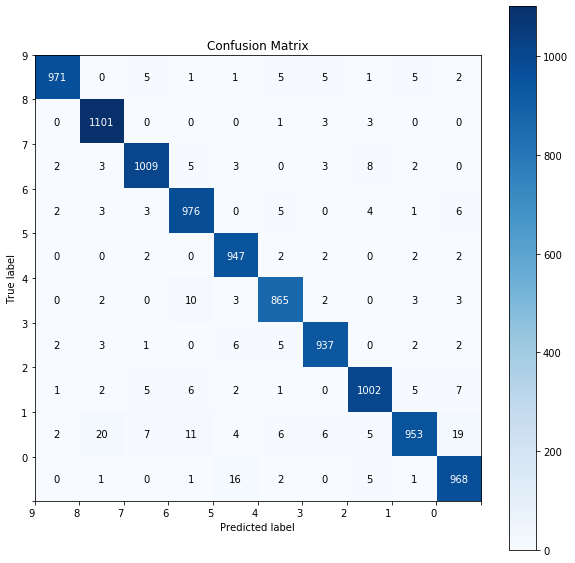

In [15]:

label_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,]

plot_confusion_matrix(predicted_labels, actual_labels, label_list)